# Adverserial Actor-Critic for MOA prediction - initial implementation

#### Alexei Stepanenko

**Aim:** Incorporate path-level and meta-paths level disciminator networks using MOA demonstration paths into the Actor-Critic framework.

This will also necessarily involve incorporating self-loop action as the meta-level network takes as input a path of fixed length. 

**Conclusions:** We seem to have implemented a working training loop, though the training is not exactly successful. Most of the time the agent stays where it is. Possible reasons include:
- Not trained for long enough
- Hyperparameters not tuned
- Entropy regularisation for the agent not implemented (i.e no exploration bonus for the agent)
- No pre-training for the discriminator networks
- We haven't excluded the possibility of a bug in the code (use notebook with caution!)

**Decision:** After this notebook, we have decided to try a simpler supervised approach, so are not pursuing this direction further. 


In [1]:
import pandas as pd
import polars as pl # much faster than pandas
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from time import time
import random
import pickle
from tqdm import tqdm
import sys
import importlib

## KG environment

First, we set up the knowledge graph environment class which the agent interacts. 

A primary function of this class is to:
 - For any given node, be able to return all successor neighbour nodes and embeddings. 
 - For any given node, be able to return out-going edges and one-hot embeddings for their predicates.

As these operations are repeated in every training step, they must be done quickly. For instance, calling a neo4j server directly to achieve this in prohibitively slow. To achieve sufficient speed, we use the graph package igraph combined with PyTorch for dealing with the embeddings.  

In addition, the class provides one-hot embeddings for the categories, as is required for the meta-path-level discriminator network.

In [2]:
SKIP = True

In [3]:
# KG filepath
KG_NODES_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/nodes_c.tsv'
KG_NODES_HEADER_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/nodes_c_header.tsv'
KG_EDGES_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/edges_c.tsv'
KG_EDGES_HEADER_PATH ='/Users/alexei/Documents/data/KGML_xDTD_data/KG/edges_c_header.tsv'
# GraphSAGE embeddings filepath 
GRAPHSAGE_EMB_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/data/entity_embeddings/unsuprvised_graphsage_entity_embeddings.pkl'
# PubMedBERT embeddings filepath 
PUBMED_EMB_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/data/entity_embeddings/embedding_biobert_namecat.pkl'

In [4]:
class KGEnv:
    """
    A class representing a knowledge graph enriched with embeddings.  
    """
    def __init__(self, 
                 kg_nodes_filepath: str,
                 kg_nodes_header_filepath: str,
                 kg_edges_filepath: str, 
                 kg_edges_header_filepath: str, 
                 embeddings_filepath: str,
                 id_col_name = "id:ID", 
                 predicate_col_name = "predicate",
                 subject_col_name = "subject",
                 object_col_name = "object"
                 ) -> None:
        """Initialises instance of the KGEnv class.

        Args:
            kg_nodes_filepath: File path for tsv file containing the KG nodes.
            kg_nodes_header_filepath: File path for tsv file containing the header for the KG nodes.
            kg_edges_filepath: File path for tsv file containing the KG edges.
            kg_edges_header_filepath: File path for tsv file containing the header for the KG edges.
            embeddings_filepath: File path for a pickle file containing an KG ID to embedding vector dictionary.
            id_col_name: Column name for KG ID in nodes tsv file.
            predicate_col_name: Column name for KG edge predicate in edges tsv file. 
            subject_col_name: Column name for KG edge subject in edges tsv file.
            object_col_name: Column name for KG edge object in edges tsv file.
        """
        # Load nodes
        print("Loading nodes...")
        nodes_header = pd.read_csv(kg_nodes_header_filepath, sep='\t', header=None).iloc[0].to_list()
        df_nodes = pl.read_csv(kg_nodes_filepath, separator='\t', has_header= False, new_columns=nodes_header)
        df_nodes = df_nodes.with_row_index()
        # Load edges
        print("Loading edges...")
        edges_header = pd.read_csv(kg_edges_header_filepath, sep='\t', header=None).iloc[0].to_list()
        df_edges = pl.read_csv(kg_edges_filepath, separator='\t', has_header= False, new_columns=edges_header)
        
        # Generate KG ID to index dictionary for nodes
        print("Generating igraph Graph instance...")
        self.node_id_to_index = {key: val for key, val in zip(list(df_nodes[id_col_name]), list(df_nodes["index"]))}
        # Generate edge predicate to index dictionary
        unique_predicates = pl.DataFrame(df_edges[predicate_col_name].unique())
        unique_predicates = unique_predicates.with_row_index()
        self.edge_predicate_to_index = {key: val for key, val in zip(list(unique_predicates[predicate_col_name]), list(unique_predicates["index"]))}
        self.edge_predicate_to_index["self-loop"] = len(self.edge_predicate_to_index) # Add self-loop label
        self.N_edge_labels = len(self.edge_predicate_to_index)
        # Generating igraph Graph instance
        edges = [(self.node_id_to_index[subject], self.node_id_to_index[object]) for subject, object in zip(df_edges[subject_col_name],df_edges[object_col_name])]
        edge_labels = {"edge_label":[self.edge_predicate_to_index[predicate] for predicate in df_edges[predicate_col_name]]}
        self.graph = ig.Graph(edges=edges, directed=True, edge_attrs = edge_labels)

        # List of categories and corresponding one-hot embeddings
        category_lst = list(df_nodes["category"].unique())
        self.category_to_index = {category: index for index, category in enumerate(category_lst)}
        self.category_embedding_matrix = torch.eye(len(category_lst))
        # Node index to category index dictionary
        self.node_index_to_category_index = {n : self.category_to_index[row["category"]] for n, row in enumerate(df_nodes.iter_rows(named=True))}

        # Remove nodes and edges from memory
        del df_nodes
        del df_edges

        # Load embeddings
        print("Loading embeddings...")
        with open(embeddings_filepath, 'rb') as file:
            embedding_dict = pickle.load(file)
        # Dimensions of embeddings matrix
        self.N_emb = len(list(embedding_dict.values())[0])
        self.N_items = len(self.node_id_to_index)        
        # Generate 2d torch tensor for embeddings. If no embedding exists, we use the zero embedding
        print("Generating embeddings matrix...")
        self.embedding_matrix = torch.zeros((self.N_items, self.N_emb))
        for _id, n in self.node_id_to_index.items():
            if _id in embedding_dict.keys():
                self.embedding_matrix[n, :] = torch.tensor(embedding_dict[_id])
        # Remove embedding dictionary from memory
        del embedding_dict

        # Matrix for one-hot edge embeddings including self-loop label
        self._edge_embedding_matrix = torch.eye(self.N_edge_labels)

        print("Initialisation successful.")


    def get_nhood_nodes(self, n: int) -> torch.Tensor:
        """Returns successor node indices and corresponding embeddings.

        Takes into account self-loop action by appending the node itself to the list of successors. 

        Args:
            n: igraph node index

        Returns:
            Tuple where the:
                - first element is a list of indices for successor nodes. 
                - second element is a 2d torch tensor with the corresponding embeddings.
            If there are no successor nodes, then a tuple of two None objects is returned.
        """
        successor_list = self.graph.successors(n)
        successor_list.append(n)  # Add self-loop
        return successor_list, self.embedding_matrix[successor_list]


    def get_out_edges(self, n: int) -> torch.Tensor:
        """Returns outgoing edge predicate indices and corresponding one-hot embeddings.

        Takes into account self-loop action by appending the self-loop label to the list of edge predicates. 

        Args:
            n: igraph node index

        Returns:
            Tuple where the:
                - first element is a list of indices for the predicates of all out edges. 
                - second element is a 2d torch tensor with the one-hot embeddings.
            If there are outgoing edges, then a tuple of two None objects is returned.
        """
        # Get indices of out edges
        edge_list = self.graph.vs[n].out_edges()
        edge_labels_lst = [edge["edge_label"] for edge in edge_list]
        edge_labels_lst.append(self.edge_predicate_to_index["self-loop"]) # Add self-loop label index
        # Return corresponding one-hot embeddings
        return edge_labels_lst, self._edge_embedding_matrix[edge_labels_lst]
    
    def get_path_category_embedding(self, path_categories: list[int], K: int) -> torch.Tensor:
        """Returns the one-hot category embedding for a given path.

        NOTE: By convention, we do not include the drug in the path category embeddings. 

        Args:
            path_categories: List of category indices for the nodes in the path, including the source drug. 
            K: Maximum number of edges in a path.
            
        Returns:
            2D torch tensor with the one-hot category embeddings for each node in the path.    
        """
        # Pad end of path with disease category 
        path_categories += [path_categories[-1] for _ in range(K + 1 - len(path_categories))] 
        # Remove source drug category
        path_categories = path_categories[1:]
        # Return embeddings
        return self.category_embedding_matrix[path_categories]

In [5]:
# Initialise KG environment
kg_env = KGEnv(KG_NODES_PATH, KG_NODES_HEADER_PATH, KG_EDGES_PATH, KG_EDGES_HEADER_PATH, GRAPHSAGE_EMB_PATH)

Loading nodes...


Loading edges...
Generating igraph Graph instance...
Loading embeddings...
Generating embeddings matrix...
Initialisation successful.


In [6]:
# Test: correct number of outgoing edges including self-loop
n_edges = len(kg_env.graph.vs[1].out_edges())
env_edges_lst, env_edges_embeddings_matrix = kg_env.get_out_edges(1)
n_edges_2 = len(env_edges_lst)
n_edges + 1 == n_edges_2

True

In [7]:
# Test (continued from above):  correct embeddings matrix size
env_edges_embeddings_matrix.shape == (n_edges + 1, kg_env.N_edge_labels) 

True

In [8]:
# Test: correct number of successor nodes including self-loop
n_successors = len(kg_env.graph.successors(1))
env_successors_lst, env_successors_embeddings_matrix = kg_env.get_nhood_nodes(1)
n_successors_2 = len(env_successors_lst)
n_successors + 1 == n_successors_2

True

In [9]:
# Test (continued from above):  correct embeddings matrix size
env_successors_embeddings_matrix.shape == (n_successors + 1, kg_env.N_emb) 

True

In [10]:
# Test: correct path category embedding
K = 6
path_categories = [0, 1, 2, 3, 4]
path_category_embedding = kg_env.get_path_category_embedding(path_categories, K)
path_category_embedding.shape == (K, kg_env.category_embedding_matrix.shape[0])

True

## Datasets

We use the demonstration path dataset extracted in KGML-xDTD

In [11]:
# Max number of hops in a path
K = 3

In [12]:
# Ground truth positive
df_tp = pd.read_csv('/Users/alexei/Documents/data/KGML_xDTD_data/known_pairs/tp_pairs.txt', sep='\t')
# Mapping to igraph indices
df_tp_mapped = df_tp.map(lambda x: kg_env.node_id_to_index[x])
# Convert to list of tuples
tp_mapped_lst = [(row["source"], row["target"]) for _, row in df_tp_mapped.iterrows()]

In [13]:
# KGML-xDTD demonstration paths
with open('/Users/alexei/Documents/data/KGML_xDTD_data/MOA_paths/demonstration_paths_entity_relation_max3_filtered.pkl', 'rb') as file:
    demonstration_paths = pickle.load(file)

In [14]:
# Separating dictionary 
path_endpoints, all_paths =  demonstration_paths.keys(), demonstration_paths.values()

In [15]:
# Perform train-test split on path_endpoints and all_paths
train_endpoints, test_endpoints, train_paths, test_paths = train_test_split(
    list(path_endpoints), 
    list(all_paths), 
    test_size=0.1, 
    random_state=42
)

# Convert back to dictionaries
train_demonstration_paths = dict(zip(train_endpoints, train_paths))
test_demonstration_paths = dict(zip(test_endpoints, test_paths))

print(f"Number of demonstration paths in training set: {len(train_demonstration_paths)}")
print(f"Number of demonstration paths in test set: {len(test_demonstration_paths)}")


Number of demonstration paths in training set: 7645
Number of demonstration paths in test set: 850


In [16]:
# Flatten the train_endpoints list
flattened_train_paths = [item for pair in train_paths for item in pair]

# Shuffle the flattened list
import random
random.seed(42)  # for reproducibility
random.shuffle(flattened_train_paths)

print(f"Number of flattened and shuffled train endpoints: {len(flattened_train_paths)}")


Number of flattened and shuffled train endpoints: 207808


In [17]:
print("Note. All paths are 3-hop: ", pd.Series([len(path)==7 for path in flattened_train_paths]).all())

Note. All paths are 3-hop:  True


In [18]:
# Removing edge predicates which are represented by lists 
train_paths_nodes_only = [[node for node in path if type(node)==str] for path in flattened_train_paths]

In [19]:
# Transforming each MOA path to form [u, e_1, ..., e_{n-1}, v]
#   where u, v, e_j are the igraph indices of the drug, disease and node indices. 
moa_mapped_lst = []
for moa_path in train_paths_nodes_only:
    moa_path_mapped = [kg_env.node_id_to_index[node_id] for node_id in moa_path]
    moa_mapped_lst.append(moa_path_mapped)

In [20]:
# Node categories for the paths
moa_categories_lst = [[kg_env.node_index_to_category_index[node_index] 
                      for node_index in moa_path]
                      for moa_path in moa_mapped_lst]

## State representation

Let $u$ represent the source drug and the $v$ the target disease. 

At each time step $t$, the agent performs an action consisting in traversing from one node $e_t$ to another $e_{t+1}$ across an edge with a given label $r_{t+1}$ .  An action is represented by a tuple $a_t = (e_{t+1}, r_{t+1})$, where $r_{t+1}$ is the edge predicate index and $e_{t+1}$ is the igraph index for the new node. 

Future actions depends only on the current state. 

There are two options for representing the state. Let $K \in \mathbb{N}$ be a cap on the number of edges in a path. 
1. Target disease accessible:
$$ s_t = [u, v, (e_{t-K}, r_{t-K}), ..., (e_{t-1}, r_{t-1}), (e_{t}, r_{t})]$$
2. Target disease inaccessible:
$$ s_t = [u, (e_{t-K}, r_{t-K}), ..., (e_{t-1}, r_{t-1}), (e_{t}, r_{t})]$$

The first corresponds to the case where the agent makes MOA predictions after a drug-disease relationship has already been made. 

The second corresponds to the case where the agent finds make disease predictions for a given drug and simultaneously provides MOA predictions. 

Zhou et. al. and KGML-xDTD opt for the second option. We shall initially focus on the first option for the $u \rightarrow v$ path-finding problem. 

**Note:** If $t \leq 0$, we replace $(e_{t}, r_{t})$ by a dummy variable $(-1,-1)$. For instance, in the first option above the initial state is
$$s_0 = (u, v, (-1,-1),...,(-1,-1)).$$

*Remark.* We could in principle let the maximum number of edges in a path be greater than the history included in the state, however, we do not do this for now. 

The path-level discriminator has access to only a reduced version of the state, 
$$ \hat{s}_t = [u, e_{t-K}, ..., e_{t-1}, e_{t}]$$

In [21]:
class Agent:
    """A class representing a reinforcement learning agent in a knowledge graph environment.  
    """
    def __init__(self, K: int, kg_env: KGEnv) -> None:
        """Initialises Agent instance.

        Args:
            K: Maximum allowed number of edges in a path
            kg_env: Instance of KGEnv 
        """
        self.K = K
        self.kg_env = kg_env
        # Initiate time
        self.time = 0
        # Initialise empty state attributes
        self.reset()

    def set_source_target(self, drug : int, disease :int) -> None:
        """Sets source drug and target diseases. Resets state to canonical initial state.  

        Args:
            drug: igraph node index for the source drug
            disease: igraph node index for the target drug
        """
        # Reset time and termination status
        self.time = 0

        # Set drug and disease indices
        self.source_drug = drug
        self.target_disease = disease
        
        # Set drug and disease embeddings
        self.source_drug_embedding = self.kg_env.embedding_matrix[drug]
        self.target_disease_embedding = self.kg_env.embedding_matrix[disease]

        # Set initial state
        self.current_state = [drug, disease] + [(-1,-1) for _ in range(self.K)]
        self.current_node = drug
        # Set initial state embedding matrix
        embeddings_tmp = torch.zeros((self.K + 2, self.kg_env.N_emb + self.kg_env.N_edge_labels))
        embeddings_tmp[0][:self.kg_env.N_emb] = self.source_drug_embedding
        embeddings_tmp[1][:self.kg_env.N_emb] = self.target_disease_embedding
        self.current_state_embedding = embeddings_tmp
        # Set reduced state embedding
        self._set_reduced_state_embedding()

        # Compute list of next possible actions
        self.compute_possible_next_actions()

    def reset(self) -> None:
        """Resets time and empties state attributes. 
        """
        self.time = 0
        self.source_drug = None
        self.source_drug_embedding = None
        self.target_disease = None
        self.target_disease_embedding = None
        self.current_state = None
        self.current_state_embedding = None
        self.reduced_state_embedding = None

    def compute_possible_next_actions(self) -> None:
        """Sets attributes containing list of next possible actions and corresponding embeddings. 
        """
        # Call KG environment to get nhood information
        successor_list, successor_embeddings_matrix = self.kg_env.get_nhood_nodes(self.current_node)
        edge_labels_list, edge_labels_embeddings_matrix = self.kg_env.get_out_edges(self.current_node)
        # Set attributes
        self.all_actions =  [
            (node_index, predicate_index) for node_index, predicate_index in zip(successor_list, edge_labels_list)
        ]
        self.all_actions_embeddings = torch.cat((successor_embeddings_matrix, edge_labels_embeddings_matrix), 1)

    def select_next_action(self, n_next_action: str):
        """Selects an admitted action and updates the agent.

        Args:
            n_next_action: Index of self.all_actions corresponding to selected next action
        """
        if self.time == self.K:
            print("Maximum path length reached.")
            return

        # Update current state and current node
        next_action = self.all_actions[n_next_action]
        self.current_node = next_action[0]
        self.current_state[2:-1] = self.current_state[3:]
        self.current_state[-1] = next_action

        # Update current state embedding 
        next_action_embedding = self.all_actions_embeddings[n_next_action]
        next_state_embedding = self.current_state_embedding.clone()
        next_state_embedding[2:-1] = self.current_state_embedding[3:]
        next_state_embedding[-1] = next_action_embedding
        self.current_state_embedding = next_state_embedding
        # Update reduced state embedding
        self._set_reduced_state_embedding()

        # Update time 
        self.time += 1

        # Update list of next possible actions
        self.compute_possible_next_actions()

    def _set_reduced_state_embedding(self) -> None:
        """Sets the reduced state embedding. 
        """
        reduced_state_embedding = self.current_state_embedding[:,:self.kg_env.N_emb] # Removing edge embeddings
        a = np.array(range(len(reduced_state_embedding)))
        reduced_state_embedding = reduced_state_embedding[a != 1] # Removing disease embedding
        self.reduced_state_embedding = reduced_state_embedding



In [22]:
# Test: initialisation and state representation
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)
print(agent.reduced_state_embedding)

[10, 42, (-1, -1), (-1, -1), (-1, -1)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [23]:
# Test: possible next actions
agent.compute_possible_next_actions()
print(agent.all_actions)
print(agent.all_actions_embeddings)

[(14984, 60), (16202, 60), (17456, 60), (17463, 60), (17935, 60), (17939, 60), (17945, 60), (17954, 60), (17969, 60), (17978, 60), (17979, 60), (18041, 60), (19175, 60), (19674, 60), (19825, 60), (20694, 60), (27303, 60), (27304, 60), (27326, 60), (27328, 60), (27330, 60), (27510, 60), (27987, 60), (28111, 60), (28784, 60), (28842, 60), (28846, 60), (29127, 60), (29711, 60), (29938, 60), (30182, 60), (30620, 60), (30661, 60), (32704, 60), (34601, 60), (35288, 60), (37142, 60), (37171, 60), (37541, 60), (37664, 60), (39829, 60), (40214, 66), (40319, 60), (43100, 60), (43139, 60), (43310, 60), (46065, 60), (46152, 60), (48768, 60), (49012, 60), (50255, 60), (50266, 60), (53257, 34), (55493, 60), (55819, 60), (58944, 60), (59556, 60), (61908, 60), (63385, 60), (64529, 60), (66616, 60), (71524, 60), (72277, 60), (73019, 60), (73903, 60), (79219, 60), (79864, 60), (81316, 60), (81336, 60), (81508, 60), (82505, 60), (84827, 60), (86269, 60), (86545, 60), (87150, 60), (88193, 60), (90728, 60)

In [24]:
# Test: selecting next action
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)
print(agent.reduced_state_embedding)
agent.select_next_action(0)
print(agent.current_state)
print(agent.current_state_embedding)
print(agent.reduced_state_embedding)
agent.select_next_action(0)
print(agent.current_state)
print(agent.current_state_embedding)
print(agent.reduced_state_embedding)
agent.select_next_action(0)

[10, 42, (-1, -1), (-1, -1), (-1, -1)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
[10, 42, (-1, -1), (-1, -1), (14984, 60)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
       

In [25]:
# Test: self-loop action
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(-1)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(-1)
print(agent.current_state)
print(agent.current_state_embedding)

[10, 42, (-1, -1), (-1, -1), (-1, -1)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
[10, 42, (-1, -1), (-1, -1), (10, 74)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  1.0000]])
[10, 42, (-1, -1), (10, 74), (10, 74)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,

In [26]:
class DemonstrationAgent:
    """A class for keeping track  of the reduced state embedding of demonstration paths. 
    """
    def __init__(self, K: int, kg_env: KGEnv, moa_path: list[int]) -> None:
        """Initialises DemonstrationAgent instance. 

        Args:
            K: Maximum allowed number of edges in a path
            kg_env: Instance of KGEnv
            moa_path: List of igraph node indices representing a MOA demonstration path
        """
        self.K = K
        self.kg_env = kg_env
        self.moa_path = moa_path
        if len(self.moa_path) > self.K + 1:
            raise ValueError("Path length exceeds maximum allowed path length.")
        # Padding the path with the last node
        self.moa_path_pad = self.moa_path + [self.moa_path[-1]] * (self.K + 1- len(self.moa_path)) 
        # Initialise reduced state embedding
        self.reduced_state_embedding = torch.zeros((self.K + 1, self.kg_env.N_emb))
        self.reduced_state_embedding[0][:self.kg_env.N_emb] = self.kg_env.embedding_matrix[moa_path[0]]
        # Initialise next node embedding
        self.next_node_embedding = self.kg_env.embedding_matrix[self.moa_path_pad[1]]
        # Initialise time
        self.time = 0
        
    def update(self) -> None:
        """Updates the reduced state embedding. 
        """
        if self.time == self.K:
            return 
        # Update time
        self.time += 1
        # Update reduced state embedding
        next_reduced_embedding = torch.zeros_like(self.reduced_state_embedding)
        next_reduced_embedding[0] = self.reduced_state_embedding[0] # Drug embedding
        next_reduced_embedding[1:-1] = self.reduced_state_embedding[2:]
        next_reduced_embedding[-1] = self.next_node_embedding #self.kg_env.embedding_matrix[self.moa_path_pad[self.time]]
        self.reduced_state_embedding = next_reduced_embedding
        # Update next node embedding
        if self.time < self.K:
            self.next_node_embedding = self.kg_env.embedding_matrix[self.moa_path_pad[self.time+1]]
        
        
        

In [27]:
# Test
_K = 5
moa_path = [10, 42, 10]
dem_agent = DemonstrationAgent(_K, kg_env, moa_path)
print(dem_agent.moa_path_pad)

[10, 42, 10, 10, 10, 10]


In [28]:
# Test
moa_path = [10, 42, 10, 42]
dem_agent = DemonstrationAgent(K, kg_env, moa_path)
print(dem_agent.time)
print(dem_agent.reduced_state_embedding)
dem_agent.update()
print(dem_agent.time)
print(dem_agent.reduced_state_embedding)
dem_agent.update()
print(dem_agent.time)
print(dem_agent.reduced_state_embedding)
dem_agent.update()
print(dem_agent.time)
print(dem_agent.reduced_state_embedding)
dem_agent.update()
print(dem_agent.time)
print(dem_agent.reduced_state_embedding)

0
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
1
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ..., -0.0725, -0.0132,  0.0248]])
2
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ..., -0.0725, -0.0132,  0.0248],
        [-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060]])
3
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0026, -0.0023, -0.0060],
        [ 0.0049,  0.0685,  0.0038,  ..., -0.0725, -0.0132,  0.0248],
        [

In [29]:
# Test: reduced state embedding shape
dem_agent.reduced_state_embedding.shape == (K + 1, dem_agent.kg_env.N_emb)

True

## Actor network

In [30]:
class ActorFCNN(nn.Module):
    """Pytorch module representing the actor network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 N_emb : int, 
                 N_edge_labels: int,
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of ActorFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            N_emb: Length of node embedding vectors. 
            N_edge_labels: Length of edge predicate embedding vectors
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Dimension of embedding of a single action 
        action_emb_dim = N_emb + N_edge_labels
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(action_emb_dim))

    def forward(self, state_embedding: torch.Tensor, all_actions_embeddings: torch.Tensor): 
        """Performs forward propagation. 

        Args:
            state_embedding: 2d torch tensor representing current state embedding 
            all_actions_embeddings: 2d torch tensor embeddings for all possible next actions
        """
        x = state_embedding.flatten()
        z = self.main_stack(x)
        return F.softmax(all_actions_embeddings @ z, dim = 0)        
        

In [31]:
# Test
neuron_lst = [10,10]
actor = ActorFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
print(actor(agent.current_state_embedding, agent.all_actions_embeddings))
print(torch.argmax(actor(agent.current_state_embedding, agent.all_actions_embeddings)).item())

tensor([0.0026, 0.0026, 0.0026, 0.0025, 0.0024, 0.0024, 0.0025, 0.0028, 0.0028,
        0.0025, 0.0026, 0.0025, 0.0025, 0.0024, 0.0025, 0.0025, 0.0024, 0.0026,
        0.0025, 0.0026, 0.0023, 0.0027, 0.0025, 0.0025, 0.0027, 0.0025, 0.0027,
        0.0024, 0.0026, 0.0024, 0.0027, 0.0027, 0.0024, 0.0024, 0.0024, 0.0027,
        0.0026, 0.0024, 0.0024, 0.0028, 0.0024, 0.0021, 0.0023, 0.0023, 0.0025,
        0.0023, 0.0020, 0.0027, 0.0027, 0.0025, 0.0023, 0.0022, 0.0024, 0.0026,
        0.0024, 0.0022, 0.0024, 0.0029, 0.0024, 0.0024, 0.0024, 0.0026, 0.0024,
        0.0025, 0.0023, 0.0025, 0.0024, 0.0022, 0.0026, 0.0023, 0.0025, 0.0026,
        0.0028, 0.0026, 0.0025, 0.0025, 0.0024, 0.0025, 0.0024, 0.0025, 0.0026,
        0.0025, 0.0025, 0.0023, 0.0025, 0.0024, 0.0025, 0.0026, 0.0026, 0.0024,
        0.0025, 0.0026, 0.0025, 0.0025, 0.0024, 0.0024, 0.0025, 0.0026, 0.0026,
        0.0027, 0.0028, 0.0024, 0.0025, 0.0026, 0.0027, 0.0026, 0.0023, 0.0022,
        0.0024, 0.0027, 0.0023, 0.0030, 

In [32]:
def run_path(agent: Agent, actor: nn.Module, drug: int, disease: int) -> list:
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.time < agent.K:
        probs_next_action = actor(agent.current_state_embedding, agent.all_actions_embeddings)
        n_next_action = torch.argmax(probs_next_action).item()
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
    return path


In [33]:
# Test
K = 6
neuron_lst = [10,10]
drug = 10
disease = 42

for _ in range (5):
    actor = ActorFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
    agent = Agent(K, kg_env)
    print(run_path(agent, actor, drug, disease))

[10, 180671, 348323, 299746, 485425, 485425, 485425]
[10, 354403, 312378, 354403, 312378, 354403, 312378]
[10, 27987, 2304176, 2304176, 2304176, 2304176, 2304176]
[10, 233576, 2676161, 2701020, 2700141, 2700141, 2700141]
[10, 435802, 468962, 260457, 2945774, 260457, 2945774]


## Critic network

In [34]:
class CriticFCNN(nn.Module):
    """Pytorch module representing the critic network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 N_emb : int, 
                 N_edge_labels: int,
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of CriticFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            N_emb: Length of node embedding vectors. 
            N_edge_labels: Length of edge predicate embedding vectors
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Dimension of embedding of a single action 
        action_emb_dim = N_emb + N_edge_labels
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(action_emb_dim))

    def forward(self, state_embedding: torch.Tensor, next_action_embedding: torch.Tensor):
        """Performs forward propagation. 

        Args:
            state_embedding: 2d torch tensor representing current state embedding 
            next_action_embedding: 1d torch tensor embeddings for an action
        """
        x = state_embedding.flatten()
        z = self.main_stack(x)
        return next_action_embedding @ z        


In [35]:
# Test
neuron_lst = [10,10]
agent = Agent(K,kg_env)
agent.set_source_target(10,42)
critic = CriticFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
print(critic(agent.current_state_embedding, agent.all_actions_embeddings[0]))

tensor(-0.2263, grad_fn=<DotBackward0>)


## Discriminator networks 

There are two discriminator networks. 
1. **Path-level discriminator network** Takes as input the concatenated embeddings of the reduced current state $\hat{s} = [u, e_{t-K}, ..., e_{t-1}, e_{t}]$ and next node $\hat{a}$. 
2. **Meta-path-level discriminator network**  Takes as input the concatenated embeddings $M$ of the path categories $(c_1, ..., c_K)$.

**NOTE:** By convention, we do not include the drug in the path category embeddings. 

In [36]:
class PathLevelDiscriminatorFCNN(nn.Module):
    """Pytorch module representing the path-level discriminator network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of PathLevelDiscriminatorFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(1))

    def forward(self, reduced_state_embedding: torch.Tensor, next_node_embedding: torch.Tensor):
        """Performs forward propagation. 

        Args:
            reduced_state_embedding: 2d torch tensor representing reduced current state embedding 
            next_node_embedding: 1d torch tensor for node embedding after next action
        """ 
        x = torch.cat([reduced_state_embedding.flatten(), next_node_embedding])
        z = self.main_stack(x)
        return F.sigmoid(z)        

In [37]:
# Test
neuron_lst = [10,10]
path_level_discriminator = PathLevelDiscriminatorFCNN(neuron_lst)
agent = Agent(K,kg_env)
agent.set_source_target(10,42)
path_level_discriminator(agent.reduced_state_embedding, agent.all_actions_embeddings[0])

tensor([0.5215], grad_fn=<SigmoidBackward0>)

In [38]:
class MetaPathLevelDiscriminatorFCNN(nn.Module):
    """Pytorch module representing the meta-path-level discriminator network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of MetaPathLevelDiscriminatorFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(1))

    def forward(self, path_category_embedding: torch.Tensor):
        """Performs forward propagation. 

        Args:
            path_category_embedding: 2d torch tensor containing one-hot embeddings for each category in the path. 
        """ 
        x = path_category_embedding.flatten()
        z = self.main_stack(x)
        return F.sigmoid(z)    

In [39]:
# Test
K = 3
neuron_lst = [10,10]
path_categories = moa_categories_lst[88]
meta_path_level_discriminator = MetaPathLevelDiscriminatorFCNN(neuron_lst)
meta_path_level_discriminator(kg_env.get_path_category_embedding(path_categories, K=agent.K))

tensor([0.4298], grad_fn=<SigmoidBackward0>)

## Training 

The loss functions for the path-level and meta-path-level discriminator networks are as follows:
$$
L_p(s,a) = - \log(D_p(\hat{s}^E,\hat{a}^E)) - \log(1 - D_p(\hat{s},\hat{a})),
$$
and
$$
L_m(M) = - \log(D_m(M^E)) - \log(1 - D_m(M)) \qquad \textrm{(terminal loss)},
$$
where 
- $s^E$ and $a^E$ are the reduced state and next node embeddings for the demonstration path at the current time step and 
- $M^E$ is the path category embedding, 

for the demonstration path.
As indicated, $L_m$ is a terminal loss meaning it is only computed when $a$ is the last action in the path. 

We construct the reward for the agent taking an action $a = (e, r)$ in a state $s$, as follows
$$R(s,a) = R_1(s,a) + R_2(s,a) + R_3(s,a),$$
where
$$
R_1(s,a) = \log(D_p(\hat{s},\hat{a})) - \log(1 - D_p(\hat{s},\hat{a})),
$$
$$
R_2(s,a) = \log(D_m(M)) - \log(1 - D_m(M)) \qquad \textrm{(terminal reward)},
$$
and
$$
R_3(s,a) = \begin{cases} 1 & \textrm{if the node } e \textrm{ is the target disease}\\
0 & \textrm{otherwise}
\end{cases} \qquad \textrm{(terminal reward)},
$$
where $D_p$ and $D_m$ are the path-level and meta-path-level discriminator networks respectively and $M$ is the set of categories one-hot embeddings for the path. 
The terminal rewards are awarded when $a$ is the last action in the path. 

The state-value function $q_\pi$ for policy $\pi$ is defined as the expected cumulative reward:
$$
q_\pi(s,a)  = \mathbb{E}_\pi[\sum_{j} \gamma^j R_j] 
$$
where $\set{R_j}$ is set of rewards achieved along the path until termination and $\gamma \in (0, 1]$ is the discount factor. 

Recall the Bellman equation for the state-value function:
$$q_\pi(s, a) = R(s,a) + \gamma \mathbb{E}_{a'\sim\pi} q_\pi(s', a') $$
where $s'$ is the state entered as a result of taking action $a$ in state $s$.

The critic network $Q$ aims to approximate the state-value function. To do this we enforce the Bellman equation using the so-called temporal difference loss:
$$
L_Q(s, a ; Q, \pi ) = (r(s,a) + \gamma \mathbb{E}_{a'\sim\pi} Q(s', a') - Q(s,a))^2.
$$

The loss for the actor network is
$$
L_\pi(s ; Q, \pi) = - \mathbb{E}_{a\sim\pi} Q(s, a).
$$

The training process is performed using an $\epsilon$-greedy strategy.

- In each epoch, we loop over the ground-truth MOA paths. 
- Each MOA path in the epoch corresponds to an episode.
- In each episode, 
    1. Start at the drug.
    2. Choose the next action as follows.  
        - With probability $1 - \epsilon$, sample according to actor policy $\pi$.
        - With probability $\epsilon$, sample randomly. 
    3. Perform gradient step. 
    4. Repeat steps 2 and 3 until termination. 

In [ ]:
# Reward functions
    
def f_reward_1(path_level_discriminator : nn.Module, reduced_state_embedding : torch.Tensor, next_node_embeddings : torch.Tensor) -> float:
    """Returns reward by path-level discriminator. 

    Args:
        path_level_discriminator: Path-level discriminator network. 
        reduced_state_embedding: 2d torch tensor representing reduced state embedding 
        next_node_embeddings: 1d torch tensor representing the next node embeddings
    """
    D_p = path_level_discriminator(reduced_state_embedding, next_node_embeddings)
    return torch.log(D_p) - torch.log(1 - D_p)

def f_reward_2(meta_path_level_discriminator : nn.Module, path_category_embedding : torch.Tensor) -> float:
    """Returns terminal reward by meta-path-level discriminator. 

    Args:
        meta_path_level_discriminator: Meta-path-level discriminator network. 
        path_category_embedding: 2d torch tensor containing one-hot embeddings for each category in the path. 
    """
    D_m = meta_path_level_discriminator(path_category_embedding)
    return torch.log(D_m) - torch.log(1 - D_m)

def f_reward_3(agent : Agent, next_action : tuple[int]) -> float:
    """Returns terminal reward for reaching the target disease. 

    Args:
        agent: Agent instance. 
        next_action: Next action in the path. 
    """
    if next_action[0] == agent.target_disease:
        return 1
    else: 
        return 0



In [245]:
# Main training loop

def train(
    kg_env : KGEnv, 
    K : int,
    moa_mapped_lst : list[int], 
    moa_categories_lst : list[int],
    actor_neuron_lst : list[int],
    critic_neuron_lst : list[int],
    discr_neuron_lst : list[int],
    meta_discr_neuron_lst : list[int],
    alpha: list[float],
    N_epochs : int,
    gamma : float,
    epsilon : float, 
    optimiser : callable,
    verbose = True,
) -> tuple[nn.Module]:
    """Train Actor-Critic network.

    Function for use in current notebook only. 

    Args:
        kg_env: Instance of KGEnv.
        K: Max number of hops.
        moa_mapped_lst : TODO
        moa_categories_lst : TODO
        actor_neuron_lst: Size of all hidden layers in actor network.
        critic_neuron_lst: Size of all hidden layers in critic network.
        discr_neuron_lst : Size of all hidden layers in discriminator network.
        meta_discr_neuron_lst : Size of all hidden layers in meta-discriminator network,
        alpha: List representing the weights [alpha_p, alpha_m] for the path level and meta-path level rewards
        N_epochs: Number of epochs.
        gamma: Discount factor. 
        epsilon: Controls epsilon-greedy policy. 
        optimiser: Function of PyTorch parameters representing optimiser. 
        verbose: Print updates during training.

    Returns:
        Tuple containing:
            - trained actor and critic networks
            - histories for average total, actor and critic loss function values per epoch.
    """
    # Initialise agent, actor network and critic networks
    agent = Agent(K, kg_env)
    actor = ActorFCNN(actor_neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
    critic = CriticFCNN(critic_neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
    path_level_discriminator = PathLevelDiscriminatorFCNN(discr_neuron_lst)
    meta_path_level_discriminator = MetaPathLevelDiscriminatorFCNN(meta_discr_neuron_lst)

    # Initialise optimiser 
    optimiser_actor = optimiser(actor.parameters())
    optimiser_critic = optimiser(critic.parameters())
    optimiser_path_level_discriminator = optimiser(path_level_discriminator.parameters())
    optimiser_meta_path_level_discriminator = optimiser(meta_path_level_discriminator.parameters())

    # Book-keeping 
    loss_hist = []
    actor_loss_hist = []
    critic_loss_hist = []
    discr_loss_hist = []
    meta_discr_loss_hist = []
    n_per_epoch = len(moa_mapped_lst)

    # Training loop
    for epoch in range(N_epochs):
        # Variables for tracking total loss for epoch
        loss_epoch = 0
        actor_loss_epoch = 0
        critic_loss_epoch = 0
        discr_loss_epoch = 0
        meta_discr_loss_epoch = 0
        # Variable for tracking number of rewards per epoch
        n_rewards_epoch = 0
        for moa, moa_categories in tqdm(zip(moa_mapped_lst, moa_categories_lst)):
            drug = moa[0]
            disease = moa[-1]

            # Reset agent
            agent.set_source_target(drug,disease)
            current_state_embedding = agent.current_state_embedding
            all_actions = agent.all_actions
            all_actions_embeddings = agent.all_actions_embeddings

            # Initialise demonstration agent
            dem_agent = DemonstrationAgent(K, kg_env, moa)

            # Run path 
            loss_episode_total = 0
            actor_loss_episode_total = 0 
            critic_loss_episode_total = 0
            discr_loss_episode_total = 0
            meta_discr_loss_episode_total = 0
            for _ in range(K): 
                #  Compute actor policy distribution for current state
                policy_probabilities = actor(current_state_embedding, all_actions_embeddings)

                # Choose next action
                probs_is_nan = torch.isnan(policy_probabilities)
                if torch.sum(probs_is_nan) == 0:
                    do_exploit = random.choices([True, False], weights = [1 - epsilon, epsilon])[0]
                else: # Do random action choice if any probabilities are nan
                    do_exploit = False
                if do_exploit:
                    # Sample from actor policy
                    n_next_action = random.choices(range(len(all_actions)), weights = policy_probabilities.tolist())[0]
                else:
                    # Sample from randomly
                    n_next_action = random.choices(range(len(all_actions)))[0]
                next_action = all_actions[n_next_action]
                next_action_embedding = all_actions_embeddings[n_next_action]

                # Compute path-level loss
                next_node_embeddings = next_action_embedding[:kg_env.N_emb]
                D_p = path_level_discriminator(agent.reduced_state_embedding, next_node_embeddings)
                D_p_dem = path_level_discriminator(dem_agent.reduced_state_embedding, dem_agent.next_node_embedding)
                path_level_loss = - torch.log(D_p_dem) - torch.log(1 - D_p)

                # Backpropagate path-level discriminator
                optimiser_path_level_discriminator.zero_grad()
                path_level_loss.backward()
                optimiser_path_level_discriminator.step()

                # Update demonstration agent
                dem_agent.update()

                # Compute meta-path-level terminal loss
                if agent.time == agent.K - 1:
                    # Compute category embedding for agent path (TODO: refactor by adding to class)
                    final_node = agent.all_actions[n_next_action][0]
                    nodes_travelled = [node for node, _ in agent.current_state[3:]]
                    nodes_in_path = [drug] + nodes_travelled + [final_node]
                    categories_in_path = [kg_env.node_index_to_category_index[node_index] for node_index in nodes_in_path]
                    path_category_embedding = kg_env.get_path_category_embedding(categories_in_path, K=agent.K)
                    # Compute category embedding for demonstration path
                    dem_path_category_embedding = kg_env.get_path_category_embedding(moa_categories, K=agent.K)
                    # Compute loss  
                    D_m = meta_path_level_discriminator(path_category_embedding)
                    D_m_dem = meta_path_level_discriminator(dem_path_category_embedding)
                    meta_path_level_loss = - torch.log(D_m_dem) - torch.log(1 - D_m)
                else:
                    meta_path_level_loss = torch.tensor(0.0, requires_grad=True)
                    
                # Backpropagate meta-path-level discriminator 
                optimiser_meta_path_level_discriminator.zero_grad()
                meta_path_level_loss.backward()
                optimiser_meta_path_level_discriminator.step()  

                # Compute actor loss
                all_critic_values = critic(current_state_embedding, all_actions_embeddings)
                loss_actor =  - all_critic_values @ policy_probabilities

                # Backpropagate actor
                optimiser_actor.zero_grad()
                loss_actor.backward()
                optimiser_actor.step()


                ## Compute total reward for chosen action
                # Path-level reward
                reward_1 = f_reward_1(path_level_discriminator, agent.reduced_state_embedding, next_node_embeddings)
                # Terminal rewards
                if agent.time == agent.K - 1:
                    # Meta-path-level reward
                    reward_2 = f_reward_2(meta_path_level_discriminator, path_category_embedding)
                    # Target disease reward
                    reward_3 = f_reward_3(agent, next_action)
                else:
                    reward_2 = 0
                    reward_3 = 0
                # Sum rewards
                reward = alpha[0]*reward_1 + alpha[1]*reward_2 + reward_3

                # Get the critic value for the chosen action
                current_critic_value = critic(current_state_embedding, next_action_embedding)

                # Update agent 
                agent.select_next_action(n_next_action)
                current_state_embedding = agent.current_state_embedding
                all_actions = agent.all_actions
                all_actions_embeddings = agent.all_actions_embeddings

                # Compute temporal difference loss for critic
                new_critic_values = critic(current_state_embedding, all_actions_embeddings)
                new_policy_probabilities = actor(current_state_embedding, all_actions_embeddings)
                new_expectation_critic =  new_critic_values @ new_policy_probabilities
                loss_critic = (reward + gamma * new_expectation_critic - current_critic_value)**2

                # Backpropagate critic
                optimiser_critic.zero_grad()
                loss_critic.backward()
                optimiser_critic.step()

                # Record history
                loss_episode_total += (loss_actor + loss_critic +  path_level_loss + meta_path_level_loss).item()
                actor_loss_episode_total += loss_actor.item()
                critic_loss_episode_total += loss_critic.item()
                discr_loss_episode_total += path_level_loss.item()
                meta_discr_loss_episode_total += meta_path_level_loss.item()
                n_rewards_epoch += reward

                
            # Record history
            loss_epoch += loss_episode_total / K
            actor_loss_epoch += actor_loss_episode_total / K
            critic_loss_epoch += critic_loss_episode_total / K
            discr_loss_epoch += discr_loss_episode_total / K
            meta_discr_loss_epoch += meta_discr_loss_episode_total / K

        # Record history        
        loss_hist.append(loss_epoch / n_per_epoch)
        actor_loss_hist.append(actor_loss_epoch / n_per_epoch)
        critic_loss_hist.append(critic_loss_epoch / n_per_epoch)
        discr_loss_hist.append(discr_loss_epoch / n_per_epoch)
        meta_discr_loss_hist.append(meta_discr_loss_epoch / n_per_epoch)
        if verbose:
            print(f"Epoch {epoch + 1}. Average reward: {n_rewards_epoch[0].item() / n_per_epoch}. Average loss: {loss_epoch / n_per_epoch}.")
    return actor, critic, path_level_discriminator, meta_path_level_discriminator, loss_hist, actor_loss_hist, critic_loss_hist, discr_loss_hist, meta_discr_loss_hist
    

#### Training a tiny NN

In [247]:
# Model hyperparameters
K = 3
actor_neuron_lst = [10,10]
critic_neuron_lst = [10,10]
discr_neuron_lst = [10,10]
meta_discr_neuron_lst = [10,10]

# Training parameters
N_epochs = 15
gamma =  0.9
epsilon = 0
optimiser = lambda params : torch.optim.Adam(params)
alpha = [0.01, 0.01]

if not SKIP:
    actor, critic, path_level_discriminator, meta_path_level_discriminator, loss_hist, actor_loss_hist, critic_loss_hist, discr_loss_hist, meta_discr_loss_hist = train(kg_env,
        K,
        moa_mapped_lst[:1000],
        moa_categories_lst[:1000],
        actor_neuron_lst,
        critic_neuron_lst,
        discr_neuron_lst,
        meta_discr_neuron_lst,
        alpha,
        N_epochs,
        gamma,
        epsilon,
        optimiser
    )

1000it [00:10, 95.65it/s]


Epoch 1. Average reward: -0.09724880218505859. Average loss: 1.1150345016835876.


1000it [00:08, 120.44it/s]


Epoch 2. Average reward: -0.21247772216796876. Average loss: 0.9613164751535886.


1000it [00:11, 87.04it/s]


Epoch 3. Average reward: -0.25543727111816406. Average loss: 0.9088655223144847.


1000it [00:07, 125.96it/s]


Epoch 4. Average reward: -0.2668577880859375. Average loss: 1.01763178721567.


1000it [00:08, 123.18it/s]


Epoch 5. Average reward: -0.20507508850097655. Average loss: 1.2277849431249002.


1000it [00:07, 131.50it/s]


Epoch 6. Average reward: -0.09364866638183594. Average loss: 1.4395507245212804.


1000it [00:07, 136.61it/s]


Epoch 7. Average reward: -0.15246754455566405. Average loss: 1.3804418414086084.


1000it [00:07, 134.90it/s]


Epoch 8. Average reward: -0.2063482666015625. Average loss: 1.3658185725982022.


1000it [00:08, 117.99it/s]


Epoch 9. Average reward: -inf. Average loss: nan.


1000it [00:08, 113.18it/s]


Epoch 10. Average reward: -0.37689947509765626. Average loss: nan.


1000it [00:08, 111.78it/s]


Epoch 11. Average reward: -inf. Average loss: nan.


1000it [00:09, 104.84it/s]


Epoch 12. Average reward: -inf. Average loss: nan.


1000it [00:08, 111.96it/s]


Epoch 13. Average reward: -inf. Average loss: nan.


1000it [00:09, 105.22it/s]


Epoch 14. Average reward: -inf. Average loss: nan.


1000it [00:09, 107.94it/s]

Epoch 15. Average reward: -inf. Average loss: nan.


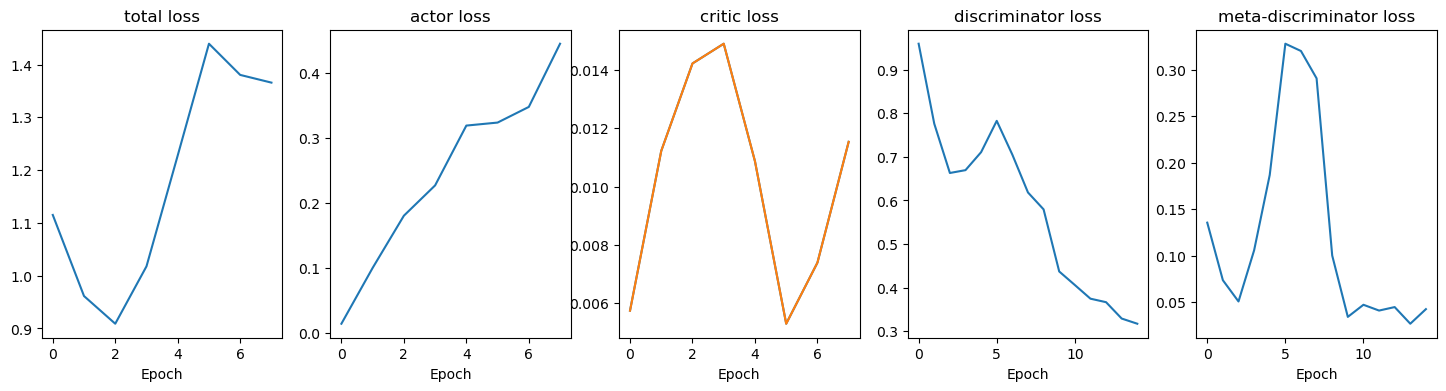

In [248]:
# Plot training curve
fig, ax = plt.subplots( 1, 5, figsize = (18, 4))
ax[0].plot(loss_hist)
ax[0].set_title("total loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(actor_loss_hist)
ax[1].set_title("actor loss")
ax[1].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[2].set_title("critic loss")
ax[2].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[3].set_title("discriminator loss")
ax[3].set_xlabel("Epoch")
ax[3].plot(discr_loss_hist)
ax[4].set_title("meta-discriminator loss")
ax[4].set_xlabel("Epoch")
ax[4].plot(meta_discr_loss_hist)
plt.show()

## Bigger Network

In [249]:
# Model hyperparameters
K = 3
actor_neuron_lst = [300, 200 ,100] # [1000, 500, 100]
critic_neuron_lst = [300, 200 ,100] # = [1000, 500, 100]
discr_neuron_lst = [300, 200 ,100] # = [1000, 500, 100]
meta_discr_neuron_lst = [300, 200 ,100] # = [1000, 500, 100]

# Training parameters
N_epochs = 30
gamma =  0.9
epsilon = 0
optimiser = lambda params : torch.optim.SGD(params, lr=0.0005, weight_decay=1e-4)
alpha = [0.005, 0.01]

# Dataset
M = 50000
moa_train = moa_mapped_lst[:M]
moa_categories_train = moa_categories_lst[:M]

if not SKIP:
    actor, critic, path_level_discriminator, meta_path_level_discriminator, loss_hist, actor_loss_hist, critic_loss_hist, discr_loss_hist, meta_discr_loss_hist  = train(kg_env,
        K,
        moa_train,
        moa_categories_train,
        actor_neuron_lst,
        critic_neuron_lst,
        discr_neuron_lst,
        meta_discr_neuron_lst,
        alpha,
        N_epochs,
        gamma,
        epsilon,
        optimiser
    )

50000it [28:56, 28.79it/s]


Epoch 1. Average reward: -0.057888720703125. Average loss: 1.3417784301768634.


50000it [28:45, 28.97it/s]


Epoch 2. Average reward: -0.15588255859375. Average loss: 0.5927702078371722.


50000it [22:19, 37.33it/s]


Epoch 3. Average reward: -0.18161623046875. Average loss: 0.5729268086712527.


50000it [20:50, 39.99it/s]


Epoch 4. Average reward: -0.18145171875. Average loss: 0.5989140078756862.


50000it [22:25, 37.16it/s]


Epoch 5. Average reward: -0.1669413671875. Average loss: 0.6633043929160977.


50000it [22:28, 37.08it/s]


Epoch 6. Average reward: -0.118078876953125. Average loss: 0.9541803878299281.


50000it [21:36, 38.58it/s]


Epoch 7. Average reward: -0.089007763671875. Average loss: 1.0916819124679211.


50000it [21:24, 38.94it/s]


Epoch 8. Average reward: -0.07509068359375. Average loss: 1.1723403778128632.


50000it [21:03, 39.56it/s]


Epoch 9. Average reward: -0.048020810546875. Average loss: 1.2982508062394418.


50000it [20:55, 39.81it/s]


Epoch 10. Average reward: -0.049830849609375. Average loss: 1.2355477500139849.


50000it [20:56, 39.78it/s]


Epoch 11. Average reward: -0.054286962890625. Average loss: 1.1892343531334986.


50000it [20:58, 39.74it/s]


Epoch 12. Average reward: -0.0596859912109375. Average loss: 1.1955626123463685.


50000it [21:24, 38.91it/s]


Epoch 13. Average reward: -0.077733388671875. Average loss: 1.1235058398111952.


50000it [21:53, 38.08it/s]


Epoch 14. Average reward: -0.111188125. Average loss: 0.8953278204533475.


50000it [22:05, 37.73it/s]


Epoch 15. Average reward: -0.139091220703125. Average loss: 0.6950754241064853.


50000it [21:57, 37.95it/s]


Epoch 16. Average reward: -0.15664896484375. Average loss: 0.5900205566164913.


50000it [21:54, 38.05it/s]


Epoch 17. Average reward: -0.16726451171875. Average loss: 0.536785325469469.


50000it [21:47, 38.24it/s]


Epoch 18. Average reward: -0.1764851171875. Average loss: 0.5004304941603396.


50000it [21:32, 38.70it/s]


Epoch 19. Average reward: -0.18269921875. Average loss: 0.47575154167447675.


50000it [21:35, 38.59it/s]


Epoch 20. Average reward: -0.18719984375. Average loss: 0.46154191637120084.


50000it [21:36, 38.56it/s]


Epoch 21. Average reward: -0.1925167578125. Average loss: 0.45041154211207063.


50000it [21:42, 38.38it/s]


Epoch 22. Average reward: -0.1944921875. Average loss: 0.4398420085842203.


50000it [22:08, 37.62it/s]


Epoch 23. Average reward: -0.19897615234375. Average loss: 0.4325371743245973.


50000it [1:26:18,  9.65it/s]


Epoch 24. Average reward: -0.2034553125. Average loss: 0.4248900761965423.


50000it [25:23, 32.81it/s]


Epoch 25. Average reward: -0.20430404296875. Average loss: 0.4214485174354109.


50000it [24:44, 33.69it/s]


Epoch 26. Average reward: -0.2072959765625. Average loss: 0.4175049468089693.


50000it [25:00, 33.33it/s]


Epoch 27. Average reward: -0.21154248046875. Average loss: 0.4118938395212476.


50000it [25:12, 33.06it/s]


Epoch 28. Average reward: -0.213723984375. Average loss: 0.4079727811076549.


50000it [2:22:00,  5.87it/s]


Epoch 29. Average reward: -0.21428630859375. Average loss: 0.400688094590157.


50000it [23:21, 35.67it/s]


Epoch 30. Average reward: -0.2138766015625. Average loss: 0.40303182260110043.


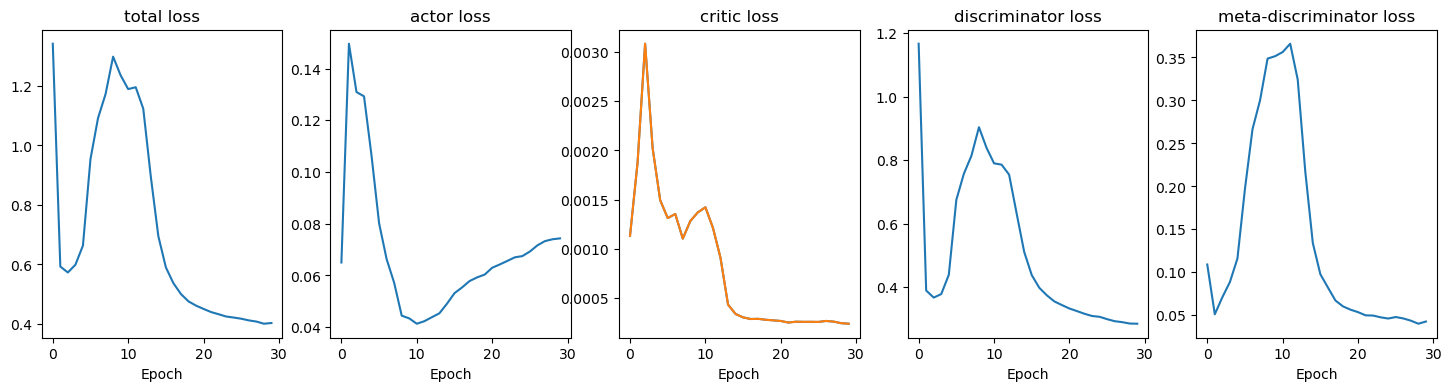

In [250]:
# Plot training curve
fig, ax = plt.subplots( 1, 5, figsize = (18, 4))
ax[0].plot(loss_hist)
ax[0].set_title("total loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(actor_loss_hist)
ax[1].set_title("actor loss")
ax[1].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[2].set_title("critic loss")
ax[2].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[3].set_title("discriminator loss")
ax[3].set_xlabel("Epoch")
ax[3].plot(discr_loss_hist)
ax[4].set_title("meta-discriminator loss")
ax[4].set_xlabel("Epoch")
ax[4].plot(meta_discr_loss_hist)
plt.show()

In [251]:
# torch.save(actor, 'output/actor.pt')
# torch.save(critic, 'output/critic.pt')
# torch.save(path_level_discriminator, 'output/path_discr.pt')
# torch.save(meta_path_level_discriminator, 'output/meta_path_discr.pt')

## Quick performance check

In [52]:
def sample_path(agent: Agent, actor: nn.Module, drug: int, disease: int, K) -> list[int]:
    """Randomly samples a actor policy path starting from a drug node. 

    Path terminated in target disease is reached.

    Args:
        agent: Instance of Agent class.
        actor: Actor network. 
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of igraph indices.
    """
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    time = 0
    while time < K:
        probs_next_action = actor(agent.current_state_embedding, agent.all_actions_embeddings)
        n_next_action = random.choices(range(len(agent.all_actions)), weights = probs_next_action.tolist())[0]
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
        if agent.current_node == disease:
            return path
        time += 1
    return path

In [53]:
K = 3
agent = Agent(K, kg_env)
actor = torch.load('output/actor.pt')

/var/folders/n9/31hlv__n1dzcrfdgr3ym1r6w0000gn/T/ipykernel_11506/2449321748.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor = torch.load('output/actor.pt')


In [72]:
N = 5000
drug = df_tp_mapped.iloc[N]["source"]
disease = df_tp_mapped.iloc[N]["target"]

In [83]:
print("drug: ", drug, "disease", disease)
sample_path(agent, actor, drug, disease, K)

drug:  11951 disease 249807


[11951, 11951, 11951, 11951]

We observe that most of the time the agent stays where it is. 